For my project I decided to analyse the Titanic data. I was mostly interested in charting the various attributes against the survival rate of the passengers, as well as a the correlation between a few pairs of attributes.

Before starting, these are the main questions I asked:
1. How are class, sex, age, number of siblings/spouses, and number of parents/children correlated to survival?
2. Is there a way I can group the cabins according to level?
3. Are embarkation ports related to the passenger class?

To start with, I simply needed to import and check the first few rows.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import seaborn as sns
import math as m
from scipy import stats as ss
from scipy.stats import chi2_contingency as c2
from statsmodels.stats import weightstats as ws

#Read our data and check that it makes sense
titanic_data = pd.read_csv('titanic_data.csv')

print titanic_data.head()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Here I wanted to create a few functions to use later that will allow me to more easily analyse the data by grouping and plotting

In [2]:
def round_to_two(x):
    """
    Args:
        x (float): The float to round to two decimal places
        
    Returns:
        float: The input float rounded to two decimal places
    """
    return round(x,2)
        

The below function allowed me to nicely plot any attribute against survival rate of the passengers, label the chart nicely, and display the survival percentages for each category.
Unfortunately, the percentages don't all display nicely due to different scalings, and I haven't quite solved that problem.

In [3]:
def survival_rate(data,column,t):
    """
    Args:
        data (float): The dataframe to summarise and plot
        column (str): The column to summarise by and show on the x axis
        t (str): The type of chart to display
        
    This function will not return anything, but will display a chart showing the survival rate according to the given attribute
    of the given dataframe
    """
    
    df=pd.DataFrame()
    df['total']=data.groupby(column).size()
    df['survived'] = data.groupby(column).sum()['Survived']
    
    #Seems I can't use round(df), hence the apply, but then I can't input a parameter, so the function round_to_two was created
    df['percentage'] = (df['survived']/df['total']*100).apply(round_to_two)
    print(df)

    #This is so that we can show the percentage labels
    ax = df['survived'].plot(kind=t)
    #These are the actual rectangle objects
    rects = ax.patches
    
    #This will loop through each rectange and together with its corresponding label.
    
    #The +10 and +20 is my attempt to lift the label for each rectangle high enough, but
    #the different scaling on the different charts makes it not as neat as I had hoped.
    for rect, i in zip(rects,df['percentage']):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 10, str(i) + '%', ha='center', va='top')
        
    for rect, i in zip(rects,df['total']):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 20, str(i), ha='center', va='bottom')
    
    #ax.text(1,2,df['percentage'])
    df['total'].plot(kind=t,alpha=0.5,title="Survivors per "+str(column))
    plt.ylabel('Number of Passengers')
    plt.show()

To test the above function, I first tested the result comparing sex to survival ratio, a simply first choice.

        total  survived  percentage
Sex                                
female    314       233       74.20
male      577       109       18.89


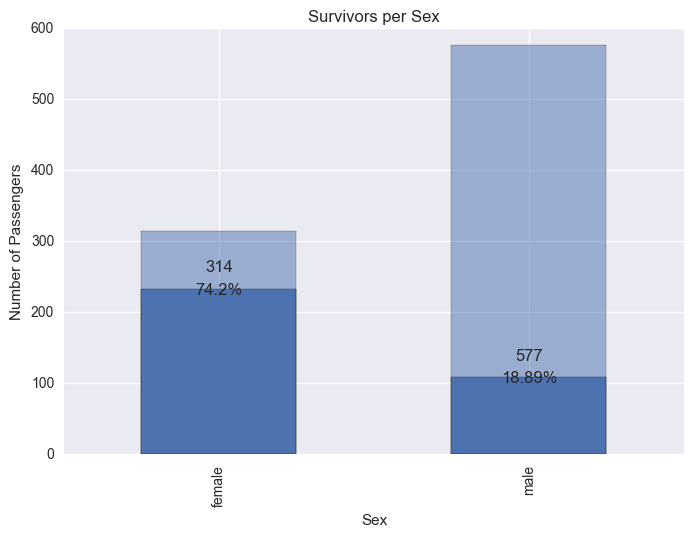

In [4]:
survival_rate(titanic_data, 'Sex','bar')

The resulting chart shows the total passengers in each group, the number of survivers, as well as the survival percentage. What we can see is that the average survival ratio of a female passenger is much higher at 74.2% than a male passenger at 18.89%.

As I listed at the beginning in my question, the following cells display the survival rates against the different attributes -- passenger class, age/age bucket, number of siblings/spouses, number of parents/children, and the cabin level.

        total  survived  percentage
Pclass                             
1         216       136       62.96
2         184        87       47.28
3         491       119       24.24


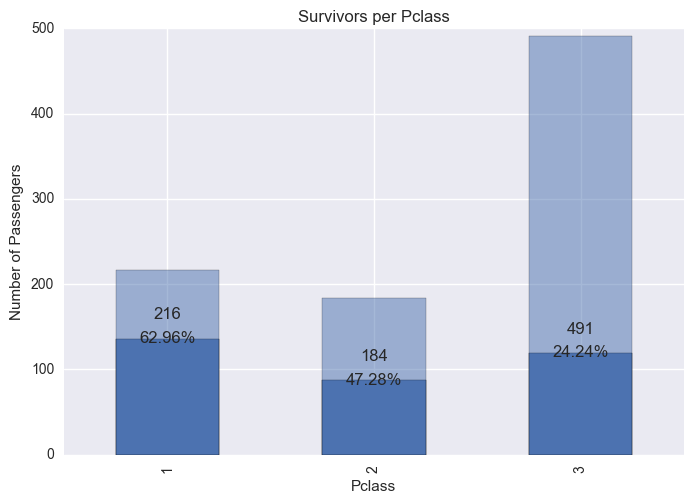

In [5]:
survival_rate(titanic_data, 'Pclass','bar')

This charts shows the (expected) result of first class passengers having a higher survival rate than third class passengers.

In order to more easily chart the age vs. survival of the passengers, I decided to group them into buckets of 10 years (except for the highest bucket, which contained 11 years, which seemed more reasonable instead of a bucket containing a very small number of 80 year old passengers). This cut function will return NaN for "Age Bucket" if any passenger is missing an "Age" value, and hence they are simply dropped from the chart.

In [6]:
titanic_data['Age Bucket'] = pd.cut (
                                    x=titanic_data['Age'],
                                    bins=[0,9,19,29,39,49,59,69,80],
                                    labels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-80"]
                                    )

print titanic_data.head()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Age Bucket  
0      0         A/5 21171   7.2500   NaN        S      20-29  
1      0          PC 17599  71.2833   C85        C      30-39  
2      0  STON/O2. 3101282   7.9250   NaN        S      20-29  
3      0            113803  53.1000  C123        S      30-39  


It appears that the buckets calculated correctly.

            total  survived  percentage
Age Bucket                             
0-9            62        38       61.29
10-19         102        41       40.20
20-29         220        77       35.00
30-39         167        73       43.71
40-49          89        34       38.20
50-59          48        20       41.67
60-69          19         6       31.58
70-80           7         1       14.29


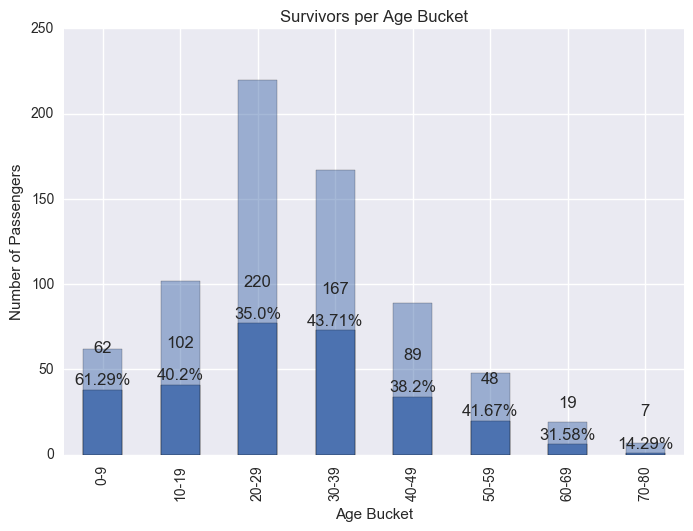

In [7]:
survival_rate(titanic_data, 'Age Bucket','bar')

A quick look at the chart shows the largest age bucket for passenger numbers was 20-29, who also had one of the lowest survival ratios. The under 10 years bucket shows the best rate of survival.

       total  survived  percentage
SibSp                             
0        608       210       34.54
1        209       112       53.59
2         28        13       46.43
3         16         4       25.00
4         18         3       16.67
5          5         0        0.00
8          7         0        0.00


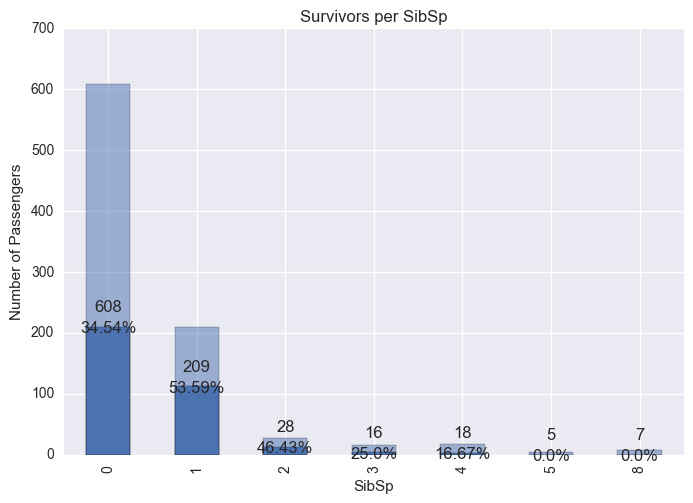

In [8]:
survival_rate(titanic_data, 'SibSp','bar')

Compared to the total number of passengers in our set, only the first two buckets have a significant number of passengers (608 and 209), and the survival ratio is not obviously different.

       total  survived  percentage
Parch                             
0        678       233       34.37
1        118        65       55.08
2         80        40       50.00
3          5         3       60.00
4          4         0        0.00
5          5         1       20.00
6          1         0        0.00


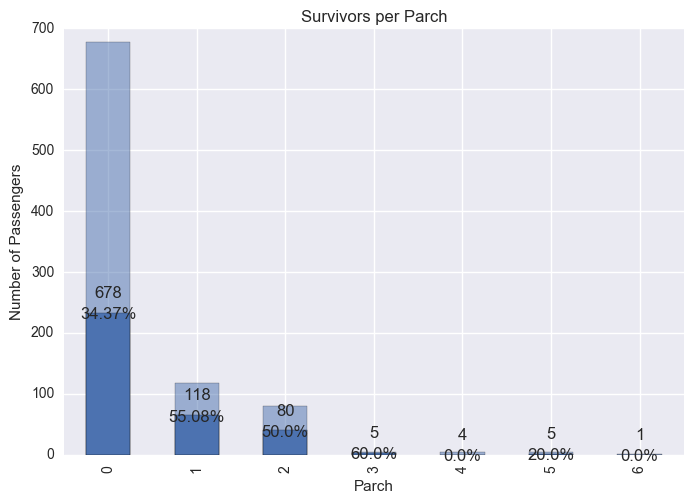

In [9]:
survival_rate(titanic_data, 'Parch','bar')

Similar to the previous chart, this chart does not tell us a whole lot. Most likely Parch and SibSp were not contributing factors to a passenger's survival.

I thought grouping the cabins together might prove interesting, assuming that the different letters correspond to different levels on the ship. Unfortunately,  many passengers do not have their cabin listed, and so the sample sizes are rather small.

In [10]:
def extract_cabin_level(cabin):
    """
    Args:
        cabin (str): The alphanumeric string representing the cabin of the passenger
        
    Returns:
        str: A string of the first letter of the input cabin string
        
    With this function create a new column for the cabin level (if there are multiple cabins for one passenger, we'll assume
    they're adjacent and so the first one will be fine)
    """
    return str(cabin)[0]

#The dropna, funnily enough, removes the NaN entries
titanic_data['Cabin Level'] = titanic_data['Cabin'].dropna().apply(extract_cabin_level)

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age Bucket,Cabin Level
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,20-29,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30-39,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,20-29,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30-39,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30-39,NaN


             total  survived  percentage
Cabin Level                             
A               15         7       46.67
B               47        35       74.47
C               59        35       59.32
D               33        25       75.76
E               32        24       75.00
F               13         8       61.54
G                4         2       50.00
T                1         0        0.00


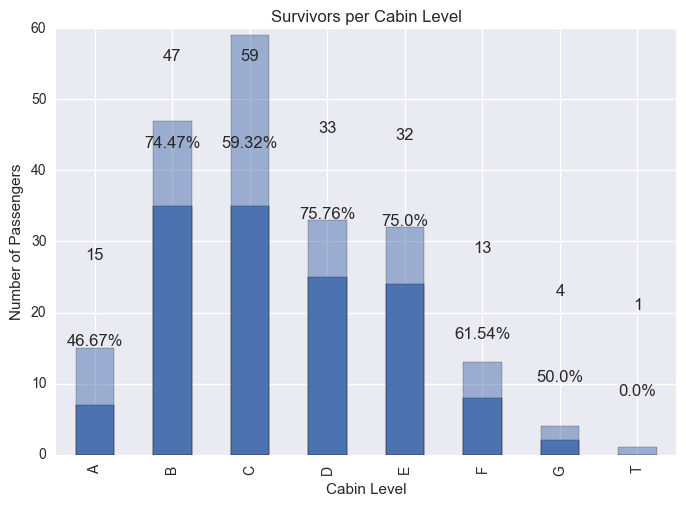

In [11]:
survival_rate(titanic_data, 'Cabin Level','bar')

Except for cabin levels A and T, all of the survival rates seem quite high, most likely an artifact of the small sample size. Perhaps only the survivors were able to record their cabins and those of their friends and family? Either way, this set is not meaningful.

By analysing the data by two variables, we might be able to get a different picture. I started out with a simple pair - age (bucket) and sex.

In [12]:
two_var = pd.DataFrame()

two_var['total'] = titanic_data.groupby(['Sex','Age Bucket'], as_index=False).size()
two_var['Survived'] = titanic_data.groupby(['Sex','Age Bucket'], as_index=True).sum()['Survived']
two_var['percentage'] = (two_var['Survived']/two_var['total']*100).apply(round_to_two)

print two_var

                   total  Survived  percentage
Sex    Age Bucket                             
female 0-9            30      19.0       63.33
       10-19          45      34.0       75.56
       20-29          72      52.0       72.22
       30-39          60      50.0       83.33
       40-49          32      22.0       68.75
       50-59          18      16.0       88.89
       60-69           4       4.0      100.00
male   0-9            32      19.0       59.38
       10-19          57       7.0       12.28
       20-29         148      25.0       16.89
       30-39         107      23.0       21.50
       40-49          57      12.0       21.05
       50-59          30       4.0       13.33
       60-69          15       2.0       13.33
       70-80           7       1.0       14.29


The results of this were a little surprising, but do make sense. We see that, for males, being under 10 years old is a great contributor to your survival, dropping from 59% to around 20% for the 10 years and older.
However, for the females, the age makes less of a difference. At a glance, it seems that the 30-39 year age bucket actually had the highest survival ratio.

A second test on the class and sex would, hopefully, yield expected results, by which I mean females of a better class having far better survival chances than the other groups.

In [13]:
two_var_second = pd.DataFrame()

two_var_second['total'] = titanic_data.groupby(['Sex','Pclass'], as_index=False).size()
two_var_second['Survived'] = titanic_data.groupby(['Sex','Pclass'], as_index=True).sum()['Survived']
two_var_second['percentage'] = (two_var_second['Survived']/two_var_second['total']*100).apply(round_to_two)

print two_var_second

               total  Survived  percentage
Sex    Pclass                             
female 1          94        91       96.81
       2          76        70       92.11
       3         144        72       50.00
male   1         122        45       36.89
       2         108        17       15.74
       3         347        47       13.54


To show these results graphically, here we have two seaborn barplots to show the difference in survival rates split by sex and cabin class, and then by age bucket and sex.

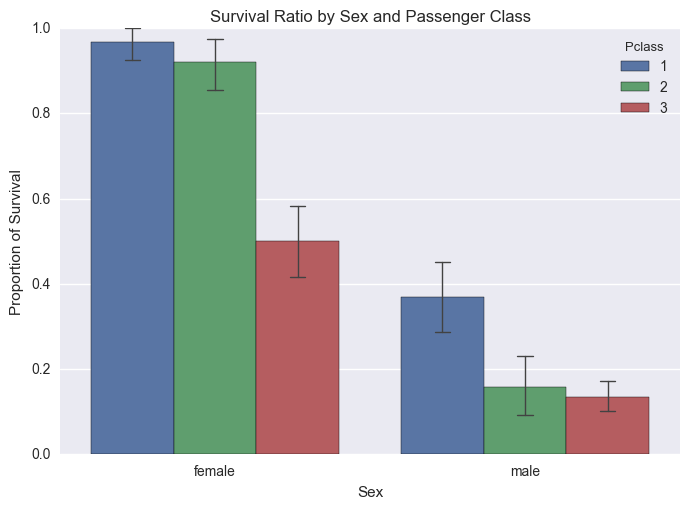

In [14]:
sns.barplot(data=titanic_data, x="Sex", order=["female","male"], hue="Pclass", y='Survived', estimator=np.mean, errwidth=1.0, capsize=.05);
plt.ylabel('Proportion of Survival');
plt.title('Survival Ratio by Sex and Passenger Class')
plt.show()

Here we can see that while the average survival rate of first class male passengers was lower than that of the third class female passengers, since the confidence intervals overlap, the difference is not statistically significant.

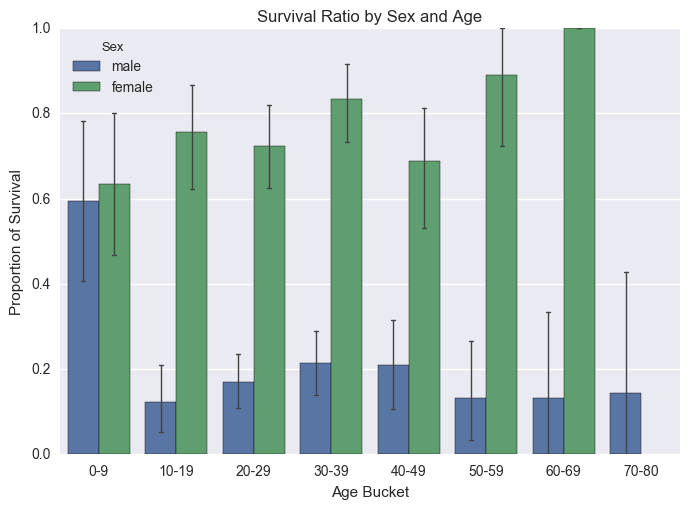

In [15]:
sns.barplot(data=titanic_data, hue="Sex", x="Age Bucket", order=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-80"], y='Survived', estimator=np.mean, errwidth=1.0, capsize=.05);
plt.ylabel('Proportion of Survival');
plt.title('Survival Ratio by Sex and Age')
plt.show()

It appears that my initial guess - that first class females having the best chance of survival out of the class and sex buckets - was correct. A whopping 96.8% of first class females survived, as opposed to 36.9% of first class males.

Below, I've tried one more visualisation to see if it's a helpful way to view the data. This heatmap shows the survival rate according to age bucket and passenger class, using the same kind of groupings as the previous two bar charts.

Pclass             1         2         3
Age Bucket                              
0-9         0.666667  1.000000  0.452381
10-19       0.833333  0.500000  0.257576
20-29       0.705882  0.415094  0.233083
30-39       0.780000  0.395833  0.217391
40-49       0.594595  0.555556  0.058824
50-59       0.555556  0.333333  0.000000
60-69       0.307692  0.333333  0.333333
70-80       0.250000  0.000000  0.000000


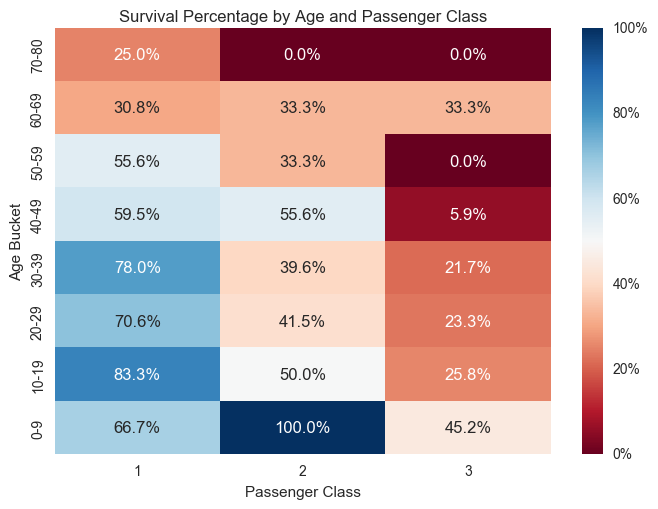

In [16]:
two_var_third = pd.DataFrame()


two_var_third['total'] = titanic_data.groupby(['Age Bucket','Pclass'], as_index=True).size()
two_var_third['Survived'] = titanic_data.groupby(['Age Bucket','Pclass'], as_index=True).sum()['Survived']
two_var_third['ratio'] = (two_var_third['Survived']/two_var_third['total'])

two_var_third_pivot = two_var_third.reset_index().pivot(index="Age Bucket",columns="Pclass",values="ratio")
print two_var_third_pivot

#This little trick for the format comes from https://github.com/mwaskom/seaborn/issues/917
fmt = lambda x, pos: '{:.0%}'.format(x)
h = sns.heatmap(two_var_third_pivot, annot=True, fmt=".1%",cmap="RdBu", cbar_kws={"format": tck.FuncFormatter(fmt)} )
h.invert_yaxis()

plt.ylabel('Age Bucket');
plt.xlabel('Passenger Class');
plt.title('Survival Percentage by Age and Passenger Class')

plt.show()

Whilst a heatmap is not ideal for this sort of categorical data, it does allow us to quickly see the "hot spots" - in this case, the combinations leading to low survival rates. The colour clearly gradiates from left to right, showing that first class to second and third class makes a big difference  in the average survival ratio of a passenger. Going from top to bottom, we can see that age does as well.

Once the simple checks were done, I had a look by eye at the different results, and performed a few chi squared-tests to check the significance of certain attributes that seemed most telling - sex and age. I decided on a chi squared test as this seemed the best way to tell significance from this categorical data for sex and age bucket. I will use an alpha of 0.05.

First Null Hypothesis: The sex and survival of a passenger are independent.   
First Alternative Hypothesis: The sex and survival of a passenger are not independent

In [17]:
#Pivot the Titanic data to get it in the form we need for the chi-squared test
pivot = pd.pivot_table(data = titanic_data[['Survived', 'Sex']], index = 'Survived', columns = ['Sex'], aggfunc = len)

#Make sure it looks right
print "Pivot table"
print pivot

#Chi-squared test
chi2, p_value, dof, expected = c2(pivot)

print "\nChi-squared score: " + str(chi2)
print "P value: " + str(p_value)
print "\nTable of expected values: "
print expected

Pivot table
Sex       female  male
Survived              
0             81   468
1            233   109

Chi-squared score: 260.717020167
P value: 1.19735706278e-58

Table of expected values: 
[[ 193.47474747  355.52525253]
 [ 120.52525253  221.47474747]]


Second Null Hypothesis: The age and survival of a passenger are independent.  
Second Alternative Hypothesis: The age and survival of a passenger are not independent

In [18]:
#Pivot the Titanic data to get it in the form we need for the chi-squared test
pivot = pd.pivot_table(data = titanic_data[['Survived', 'Age Bucket']], index = 'Survived', columns = ['Age Bucket'], aggfunc = len)

#Make sure it looks right
print "Pivot table"
print pivot

#Chi-squared test
chi2, p_value, dof, expected = c2(pivot)

print "\nChi-squared score: " + str(chi2)
print "P value: " + str(p_value)
print "\nTable of expected values: "
print expected

Pivot table
Age Bucket  0-9  10-19  20-29  30-39  40-49  50-59  60-69  70-80
Survived                                                        
0            24     61    143     94     55     28     13      6
1            38     41     77     73     34     20      6      1

Chi-squared score: 17.4277216059
P value: 0.0148368781128

Table of expected values: 
[[  36.81792717   60.57142857  130.6442577    99.17086835   52.85154062
    28.50420168   11.28291317    4.15686275]
 [  25.18207283   41.42857143   89.3557423    67.82913165   36.14845938
    19.49579832    7.71708683    2.84313725]]


It is clear from the above results that males and females have statistically signifant differences in their survival ratio - the p-value is far less than 0.05. The survival is also not independent to age bucket, with a p-value of 0.015.

However, as we saw from the 2D test above, the significance of age also depends on sex, and the larger number of males in the sample influences the chi-squared test results. This can be seen in the barplot above ("Survival Ratio by Sex and Age"), where the significant difference in survival rate between under 10 males and over 10 males can be seen, even though for females that difference does not exist.

Here I wanted to check the actual correlation of a few of the attributes to survival. None of the results are very strong, with class being the highest at -0.33, meaning that as your class gets worse (from 1 to 2 to 3) you have a lower chance of survival. This intuitively makes sense.

In [19]:
#Some correlation tests
print titanic_data['Age'].corr( titanic_data['Survived'] )
print titanic_data['Pclass'].corr( titanic_data['Survived'] )
print titanic_data['SibSp'].corr( titanic_data['Survived'] )
print titanic_data['Parch'].corr( titanic_data['Survived'] )

-0.0772210945722
-0.338481035961
-0.0353224988857
0.0816294070835


This final chart and table are answers to two questions that I simply found interesting - what is the age distrubution of the passengers according to sex? And, what is the cabin class distribution according to embarkation point?

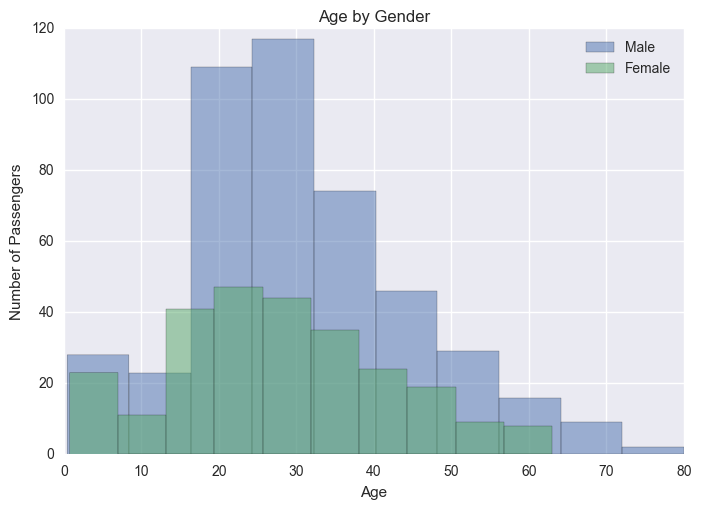

In [20]:
nice_chart, ax1 = plt.subplots(1,1)
#The dropna() in the below two lines is to prevent the histogram from complaining
#about missing values
ax1.hist(titanic_data.loc[titanic_data['Sex'] == 'male']['Age'].dropna(), alpha = 0.5, label = 'Male', normed = False)
ax1.hist(titanic_data.loc[titanic_data['Sex'] == 'female']['Age'].dropna(), alpha = 0.5, label = 'Female', normed = False)
#ax1.set_xticks(range(0,8))
ax1.legend()
ax1.set_title('Age by Gender')
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of Passengers')

plt.show()

Both men and women had more passengers between 20 and 30 than any other age bracket, and the  rest of the distribution is very similar between both.

In [21]:
class_embark_df = pd.DataFrame()

#This clever percentage of total came from http://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
class_embark_df['Total'] = titanic_data.groupby(["Embarked","Pclass"], as_index=True).size()
class_embark_df['Percentage by Embarkation'] = class_embark_df['Total'].groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

print class_embark_df

                 Total  Percentage by Embarkation
Embarked Pclass                                  
C        1          85                  50.595238
         2          17                  10.119048
         3          66                  39.285714
Q        1           2                   2.597403
         2           3                   3.896104
         3          72                  93.506494
S        1         127                  19.720497
         2         164                  25.465839
         3         353                  54.813665


C = Cherbourg, France
Q = Queenstown (now Cobh), Ireland
S = Southampton, England

It does appear that the port of embarkation with the highest proportion of first class passengers was Cherbourg, France with 50.6%, and Queenstown, Ireland had the lowest with 2.6%. It appears  that the answer to the question "Is there a relationship between port of embarkation and passenger class?" is yes.

One limitation in all of this analysis is the missing passengers. Of the 2,224 passengers on board, this dataset contains only 891, representing approximately 40% of the total. There could be entire segments of the passengers that we are missing - for example, many young third class passengers which might change the age and sex vs. survival chart. Unfortunately, not knowing the kind of data that is missing does not give me many options. For this analysis, I have simply worked with what I have and assumed that it is representative, which certainly will skew the results in the likely case that it is not representative.

A positive is that out of the passenger data that we have, a vast majority of the characteristics are present. Analysing the .csv file shows missing values only for age (177 missing out of 891 - 19.9%) and cabin (687 missing out of 891 - 77.1%), so only our age bucket and cabin charts and tables are missing data. With such a large proportion of missing cabin data, the chart showing cabin vs. survival is not meaningful and may even be misleading. When analysing these two attributes, I simply ignored the missing values, rather than interpolating them. For cabin it was because so few records were present, trying to interpolate the data would have been wildly inaccurate.

In conclusion, from collating these results, it *appears* that being a female in first class gave you the best chance of survival during the sinking of the Titanic, but then your age did not make a significant difference. If you were male, being under 10 years also helped a lot, though of course all we can see here is correlation. This is consistent with the policy of women and children first that the evacuation operation followed. However, as mentioned above, with unknown segments of data that are missing, we cannot make any firm conclusions on causation.